In [1]:
import os, json, pickle, sys, torch, shutil
sys.path.append('../')
from src.utils.visualization import plot_scatter, read_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import gaussian_kde
import seaborn as sns
from pathlib import Path
plt.rcParams['font.size'] = 13

In [39]:
cmap1 = lambda x: [np.min([x*2+0.5,1]), x*0.8, x*0.6]
cmap2 = lambda x: [x*0.7, np.min([x*2+0.2,1]), np.min([x*0.7+0.2, 1])]
cmap3 = lambda x: [x*0.3, x*0.9, np.min([x*2+0.5, 1])]

def _parse_data(fn):
    with open(fn, 'rb') as f:
        ids, t, p = pickle.load(f)
    o = np.argsort(ids)
    t, p = t.reshape(-1), p.reshape(-1)
    r2, mae = r2_score(t, p), mean_absolute_error(t, p)
    return {'r2':r2, 'mae':mae, 'id':ids[o], 't':t[o], 'p':p[o]}

def get_output(root, tag, fmt='n_{:03d}', epoch='best', dataset=['train','valid','test']):
    output = {ds:[] for ds in dataset}
    path = os.path.join(root, tag)
    if not os.path.isdir(path):
        return output
    for i in range(100):
        dn = os.path.join(path, fmt.format(i))
        for ds in dataset:
            dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
            if not os.path.isfile(dfn): 
                continue
            output[ds].append(_parse_data(dfn))
    return output

def get_cvout():
    cv_errs = {}
    for tune in ['scratch','finetune']:
        _root = f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/{tune}_cs'
        nets = ['mol','graph','concat']
        for cond in sorted(os.listdir(_root)):
            path_cond = os.path.join(_root, cond)
#            cond = cond.replace('_s0','_s')
            for net in nets:
                path = os.path.join(path_cond, net)
                if not os.path.isdir(path): continue
                for tag in sorted(os.listdir(path)):
                    if f'{cond}_{net}_{tag}' not in cv_errs.keys():
                        cv_errs[f'{cond}_{net}_{tag}'] = {
                            'train':{'scratch':{},'finetune':{}}, 
                            'valid':{'scratch':{},'finetune':{}}, 
                            'test':{'scratch':{},'finetune':{}},
                            'score':{'scratch':{},'finetune':{}},
                        }
                    path_tag = os.path.join(path, tag)
                    output = get_output(path, tag, fmt='n_{:03d}', epoch='best')
                    mfn = os.path.join(path_tag, 'n_000/best.model.torch')
                    if not os.path.isfile(mfn): continue
#                    line = f'{net:10s}/{tag:20s} {cond:20s} / '
                    score = np.zeros(len(output['train']))
                    for ds in ['train','valid','test']:
                        out = output[ds]
                        r2, mae = np.array([v['r2'] for v in out]), np.array([v['r2'] for v in out])
                        
                        cv_errs[f'{cond}_{net}_{tag}'][ds][tune]['r2'] = np.array([v['r2'] for v in out])
                        cv_errs[f'{cond}_{net}_{tag}'][ds][tune]['mae'] = np.array([v['mae'] for v in out])
                        cv_errs[f'{cond}_{net}_{tag}'][ds][tune]['p'] = [v['p'] for v in out]
                        cv_errs[f'{cond}_{net}_{tag}'][ds][tune]['t'] = [v['t'] for v in out]
                        if ds != 'test':
                            score += r2.squeeze() - 0.02 * mae.squeeze()
#                        for s, val in zip(['R2','MAE'], [r2, mae]):
#                            avg = np.mean(val)
#                            std = np.std(val)
#                            print(ds, '\t', s, '\t/ ', ' / '.join([f'{v:6.3f} ±{e:.3f}' for v, e in zip(avg, std)]))
#                            line += f' {avg:6.3f} ±{std:.3f} /'
#                        line += '/'
                    cv_errs[f'{cond}_{net}_{tag}']['score'][tune] = score
    return cv_errs

In [40]:
metrics = ['r2','mae']
tunes = ['scratch','finetune']
datasets = ['train','valid','test']
cv_errs = get_cvout()
tags = np.array([k for k in cv_errs.keys()])
errs_bf = {i:{met:{m:[] for m in tunes} for met in metrics} for i in range(5)}
pred_bf = {i:{ds:{m:[] for m in tunes} for ds in datasets} for i in range(5)}
tgts_bf = {i:{ds:None for ds in datasets} for i in range(5)}
scor_bf = {i:{m:None for m in tunes} for i in range(5)}

valid_r2s = {tune:np.array([v['valid'][tune]['r2'] for v in cv_errs.values()]).T for tune in tunes}
valid_maes = {tune:np.array([v['valid'][tune]['mae'] for v in cv_errs.values()]).T for tune in tunes}
train_r2s = {tune:np.array([v['train'][tune]['r2'] for v in cv_errs.values()]).T for tune in tunes}
train_maes = {tune:np.array([v['train'][tune]['mae'] for v in cv_errs.values()]).T for tune in tunes}
test_r2s = {tune:np.array([v['test'][tune]['r2'] for v in cv_errs.values()]).T for tune in tunes}
test_maes = {tune:np.array([v['test'][tune]['mae'] for v in cv_errs.values()]).T for tune in tunes}
valid_scors = {tune:r - 0.05 * m for (tune, r), m in zip(valid_r2s.items(), valid_maes.values())}

for v1 in cv_errs.values():
    for m in tunes:
        for metric in metrics:
            for i in range(5):
                errs_bf[i][metric][m].append([
                    v1['train'][m][metric][i], v1['valid'][m][metric][i], v1['test'][m][metric][i]
                ])
        for i in range(5):
            for ds in datasets:
                pred_bf[i][ds][m].append(v1[ds][m]['p'][i])
for ds in datasets:
    for i in range(5):
        tgts_bf[i][ds] = v1[ds]['scratch']['t'][i]
for i in range(5):
    for m in tunes:
        rt, rv, _ = np.array(errs_bf[i]['r2'][m]).T
        mt, mv, _ = np.array(errs_bf[i]['mae'][m]).T
        s = rt + rv - (mt + mv) * 0.02
#        s[rt < 0.9] = 0
        scor_bf[i][m] = s

pred_best = {}
for tune in tunes:
    pred_best[tune] = {'train':[],'valid':[], 'test':[]}
    for i,j in enumerate(valid_r2s[tune].argmax(1)):
        pred_best[tune]['train'].append(pred_bf[i]['train'][tune][j])
        pred_best[tune]['valid'].append(pred_bf[i]['valid'][tune][j])
        pred_best[tune]['test'].append(pred_bf[i]['test'][tune][j])

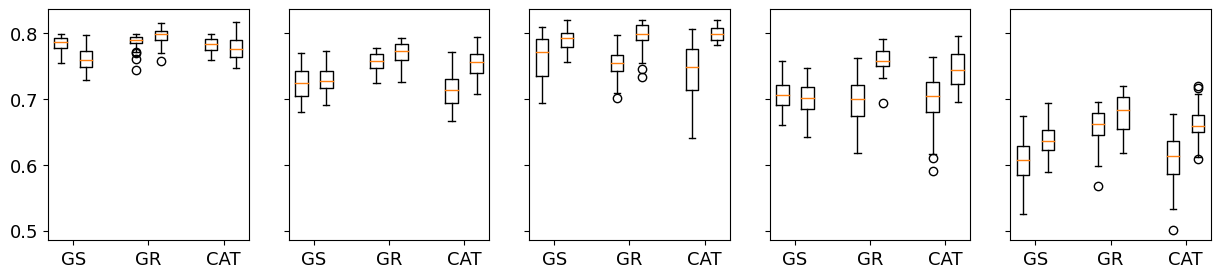

In [41]:
f, axs = plt.subplots(1,5,figsize=(15, 3), sharey=True)
for i, ax in enumerate(axs):
    for j, tune in enumerate(['scratch','finetune']):
        val = valid_r2s[tune][i]
        for k, net in enumerate(['mol','graph','concat']):
            mask = np.array([net in _tag for _tag in tags])
            ax.boxplot(val[mask], positions=[j + k*3], widths=0.5)
    ax.set_xticks([0.5, 3.5, 6.5], labels=['GS','GR','CAT'])
#            ax.scatter([j+k*3]*np.sum(mask), val[mask], facecolor=[0.3,0.3,0.3], edgecolor=[0,0,0], alpha=0.5)
            
            #ax.violinplot(val[mask], positions=[j+k*3])
            #sns.swarmplot(val[mask], , ax=ax)

- copy results

In [42]:
data = list(cv_errs.values())
mapper = {'mol':'gs', 'graph':'gr', 'concat':'grgs', '_':'all'}
for net in ['mol','graph','concat']:
    mask = np.array([net in _tag for _tag in tags])
    for tune, vr2s in valid_r2s.items():
        avgs = vr2s.mean(0)
        j = np.where(mask)[0][vr2s.T[mask].mean(1).argmax()]
        t = tags[j].split('_')
        root = os.path.join(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/{tune}_cs/', 
                            '_'.join(t[:3]), t[3], '_'.join(t[4:]))
        vals = []
        pred = []
        print(net, tune, ':', tags[j])
        os.makedirs(f'../outputs/models/{tune}/{mapper[t[3]]}_hp', exist_ok=True)
        os.makedirs(f'../outputs/results/{tune}/{mapper[t[3]]}_hp', exist_ok=True)
        f_hp = open(f'../outputs/models/{tune}/{mapper[t[3]]}_hp/tuning_hp.txt','w')
        for i in range(5):
            f_hp.write(tags[j] +'\n')
            path = os.path.join(root, f'n_00{i}')
            for fn in ['best.model.torch','best.loss.txt','best.params.txt','param.json','scale.json']:
                shutil.copy(os.path.join(path, fn),
                            os.path.join(f'../outputs/models/{tune}/{mapper[t[3]]}_hp', f'fold_{i}_{fn.replace("best.","")}'))
            s = f'Fold : {i} | '
            for ds in ['train','valid','test']:
                shutil.copy(os.path.join(path, f'best.{ds}.pkl'),
                            os.path.join(f'../outputs/results/{tune}/{mapper[t[3]]}_hp', f'fold_{i}_{ds}.pkl'))
                for metric in ['r2','mae']:
                    v = data[j][ds][tune][metric][i]
                    s += ' {:7.3f}'.format(v)
                    vals.append(v)
                s += ' / '
            pred.append(data[j]['test'][tune]['p'][i])
            print(s)
        print('-'*80)
        f_hp.close()
        vals = np.array(vals).reshape(5,-1)
        print('AVG  : _ |  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f}'.format(*vals.mean(0)))
        print('STD  : _ |  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f}'.format(*vals.std(0)))
        x1 = data[j]['test'][tune]['t'][0]
        y1 = np.mean(pred, 0)
        print('-'*80)
        print('{:46s} /  {:7.3f} {:7.3f}'.format('',r2_score(x1, y1), mean_absolute_error(x1, y1)))
        print()

mol scratch : b08_g99_s25_mol_sing_dnn_128_2
Fold : 0 |    0.973   2.670 /    0.788  10.768 /    0.376  10.368 / 
Fold : 1 |    0.925   4.922 /    0.753   9.098 /    0.210  10.744 / 
Fold : 2 |    0.952   3.481 /    0.793  10.186 /    0.374  10.201 / 
Fold : 3 |    0.958   3.574 /    0.758  10.034 /    0.214  11.557 / 
Fold : 4 |    0.970   3.290 /    0.631  12.442 /    0.395  10.284 / 
--------------------------------------------------------------------------------
AVG  : _ |    0.956   3.587 /    0.745  10.506 /    0.314  10.631
STD  : _ |    0.017   0.738 /    0.059   1.107 /    0.083   0.499
--------------------------------------------------------------------------------
                                               /    0.500   9.105

mol finetune : b04_g99_s50_mol_sing_dnn_128_2
Fold : 0 |    0.962   3.683 /    0.798  10.121 /    0.190  11.162 / 
Fold : 1 |    0.969   3.192 /    0.717   9.645 /    0.109  11.462 / 
Fold : 2 |    0.964   2.742 /    0.786  10.390 /    0.438  10.381

In [43]:
data = list(cv_errs.values())
for net in ['mol','graph','concat','_']:
    mask = np.array([net in _tag for _tag in tags])
    for tune, vr2s in valid_r2s.items():
        vals = []
        pred = []
        root = f'../outputs/{tune}/{mapper[net]}_ens'
        os.makedirs(root, exist_ok=True)
        print(tune)
        f_hp = open(os.path.join(root, 'tuning_hp.txt'),'w')
        for i, k in enumerate(vr2s[:, mask].argmax(1)):
            j = np.where(mask)[0][k]
            f_hp.write(tags[j] +'\n')
            t = tags[j].split('_')
            path = os.path.join(f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/{tune}_cs/', 
                                '_'.join(t[:3]), t[3], '_'.join(t[4:]), f'n_00{i}')
            for fn in ['best.model.torch','best.loss.txt','best.params.txt','param.json','scale.json']:
                shutil.copy(os.path.join(path, fn),
                            os.path.join(root, f'fold_{i:02d}', fn.replace('best.','')))

            v = data[j][ds][tune][metric][i]
            s = f'Fold : {i} | '
            for ds in ['train','valid','test']:
                shutil.copy(os.path.join(path, f'best.{ds}.pkl'),
                            os.path.join(root, f'fold_{i:02d}', f'{ds}.pkl'))
#                out = _parse_data(os.path.join(root, f'fold_{i:02d}', f'{ds}.pkl'))
#                print('{:8.4f} {:8.4f} {:8.4f} {:8.4f}'.format(out['r2'], data[j][ds][tune]['r2'][i], out['mae'], data[j][ds][tune]['mae'][i]))
                for metric in ['r2','mae']:
                    v = data[j][ds][tune][metric][i]
                    s += ' {:7.3f}'.format(v)
                    vals.append(v)
                s += ' / '
            pred.append(data[j]['test'][tune]['p'][i])
            print(s, tags[j])
        f_hp.close()

        print('-'*80)
        vals = np.array(vals).reshape(5,-1)
        print('AVG  : _ |  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f}'.format(*vals.mean(0)))
        print('STD  : _ |  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f} /  {:7.3f} {:7.3f}'.format(*vals.std(0)))
        x1 = data[j]['test'][tune]['t'][0]
        y1 = np.mean(pred, 0)
        print('-'*80)
        print('{:46s} /  {:7.3f} {:7.3f}'.format('',r2_score(x1, y1), mean_absolute_error(x1, y1)))
        print()        

scratch
Fold : 0 |    0.941   3.497 /    0.799  10.235 /    0.401  10.319 /  b04_g95_s50_mol_sing_dnn_128_2
Fold : 1 |    0.923   4.591 /    0.771   8.561 /    0.209  10.343 /  b08_g99_s50_mol_sing_dnn_256_2
Fold : 2 |    0.963   2.227 /    0.809   9.833 /    0.456  10.074 /  b04_g75_s50_mol_sing_dnn_256_2
Fold : 3 |    0.958   3.574 /    0.758  10.034 /    0.214  11.557 /  b08_g99_s25_mol_sing_dnn_128_2
Fold : 4 |    0.960   3.052 /    0.675  11.736 /    0.454  10.254 /  b04_g99_s25_mol_sing_dnn_128_2
--------------------------------------------------------------------------------
AVG  : _ |    0.949   3.388 /    0.762  10.080 /    0.347  10.509
STD  : _ |    0.015   0.769 /    0.048   1.014 /    0.112   0.532
--------------------------------------------------------------------------------
                                               /    0.544   9.077

finetune
Fold : 0 |    0.962   3.683 /    0.798  10.121 /    0.190  11.162 /  b04_g99_s50_mol_sing_dnn_128_2
Fold : 1 |    0.935   

In [59]:
outputs = {
    'valid':{
        'scratch':{'pred':[], 'target':[],},
        'finetune':{'pred':[], 'target':[],}
    },
    'test':{
        'scratch':{'pred':[], 'target':[],},
        'finetune':{'pred':[], 'target':[],}
    }    
}
for tune in ['scratch','finetune']:
    for i in range(5):
        for ds in ['valid','test']:
            with open(f'../outputs/{tune}/all_ens/fold_{i:02d}/{ds}.pkl','rb') as f:
                v = pickle.load(f)
            outputs[ds][tune]['pred'].append(v[2].reshape(-1))
            outputs[ds][tune]['target'].append(v[1].reshape(-1))

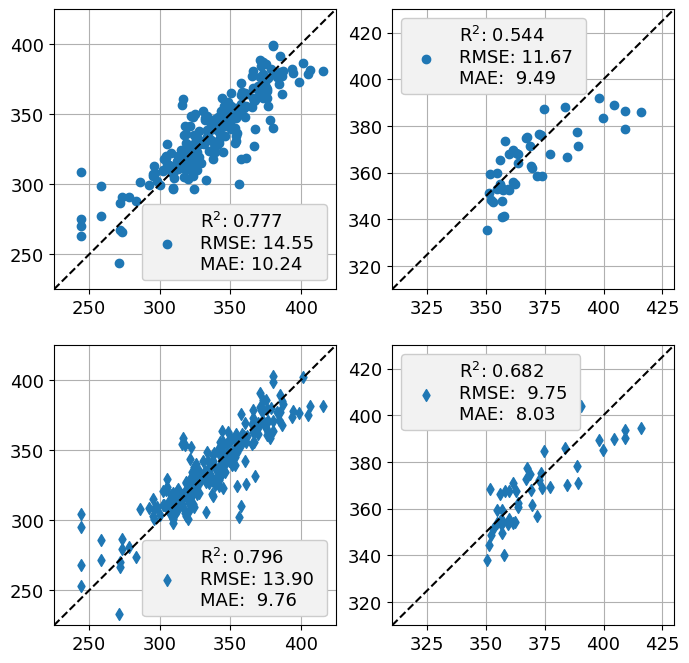

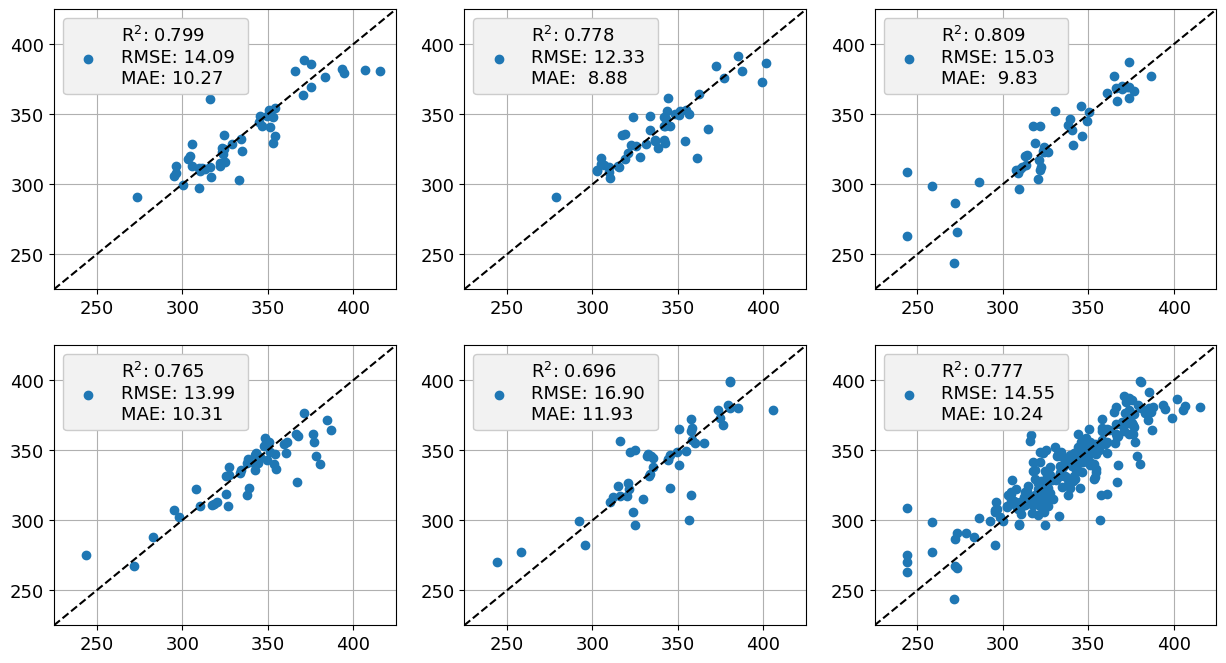

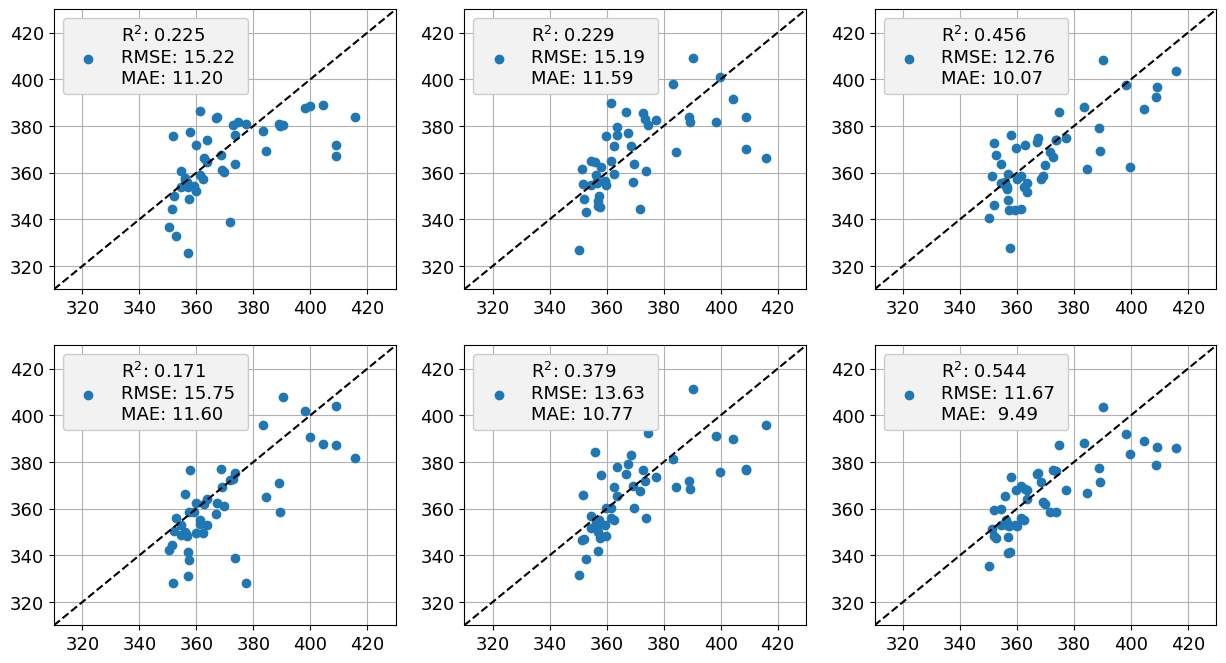

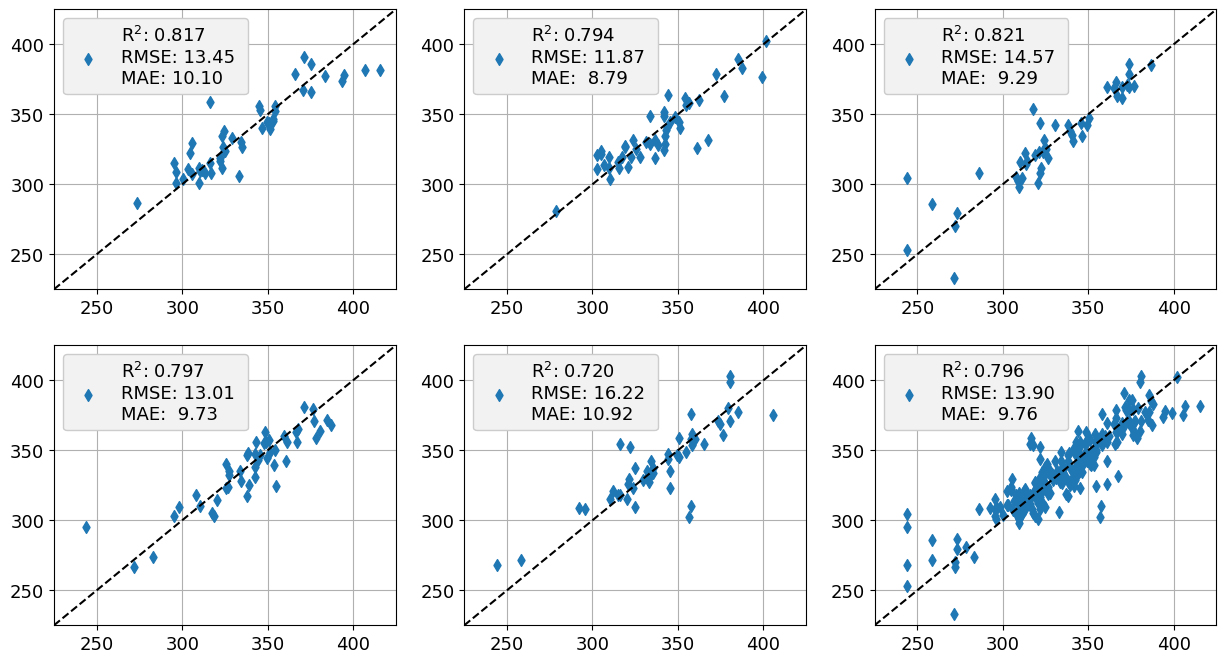

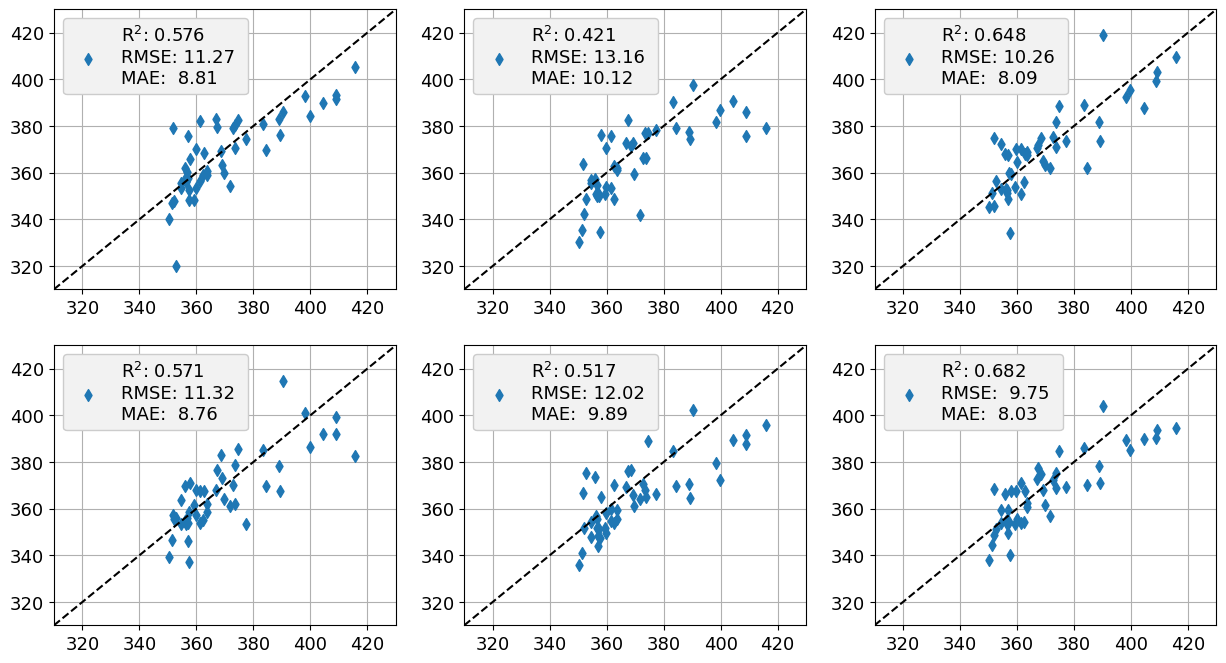

In [60]:
f1, axs1 = plt.subplots(2,2,figsize=(8,8))
marker = ['o','d']
for i, model in enumerate(['scratch','finetune']):
    x1 = np.hstack(outputs['valid'][model]['target']) + 273.15
    y1 = np.hstack(outputs['valid'][model]['pred']) + 273.15
    x2 = outputs['test'][model]['target'][0] + 273.15
    y2 = np.mean(outputs['test'][model]['pred'], 0) + 273.15
    plot_scatter(axs1[i,0], x1, y1, xrange=[225, 425], marker=marker[i])
    plot_scatter(axs1[i,1], x2, y2, xrange=[310, 430], marker=marker[i])

    f2, axs2 = plt.subplots(2,3,figsize=(15,8))
    axs2 = axs2.reshape(-1)
    for j in range(5):
        x0 = outputs['valid'][model]['target'][j] + 273.15
        y0 = outputs['valid'][model]['pred'][j] + 273.15
        plot_scatter(axs2[j], x0, y0, xrange=[225, 425], marker=marker[i])
    plot_scatter(axs2[-1], x1, y1, xrange=[225,425], marker=marker[i])
#    f2.savefig(f'./figs/output.{model}.valid.pdf')

    f2, axs2 = plt.subplots(2,3,figsize=(15,8))
    axs2 = axs2.reshape(-1)
    for j in range(5):
        y3 = outputs['test'][model]['pred'][j] + 273.15
        plot_scatter(axs2[j], x2, y3, xrange=[310, 430], marker=marker[i])
    plot_scatter(axs2[-1], x2, y2, xrange=[310,430], marker=marker[i])
#    f2.savefig(f'./figs/output.{model}.test.pdf')
#f1.savefig(f'./figs/output.all.valid.pdf')

(310.0, 430.0)

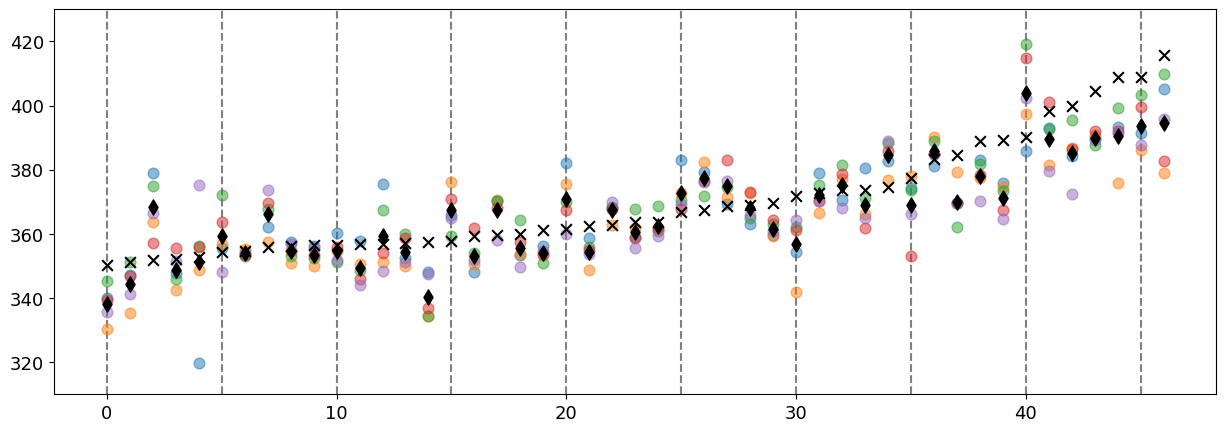

In [61]:
f, ax = plt.subplots(1,1,figsize=(15,5))
ps = outputs['test']['finetune']['pred']
t = outputs['test']['finetune']['target'][0] + 273.15
x = np.arange(t.shape[0])
x = np.argsort(t).argsort()
for i in range(10):
    ax.axvline(i*5, ls='--', color=[0.5,0.5,0.5])
for i, p in enumerate(ps):
    ax.scatter(x, p+273.15, zorder=80, alpha=0.5, s=60)
ax.scatter(x, t, marker='x', color=[0,0,0], zorder=95, s=60)
ax.scatter(x, np.mean(ps, 0)+273.15, marker='d', color=[0,0,0], zorder=95, s=60)
ax.set_ylim([310,430])
#f.savefig('./figs/output.test.support.all.pdf')

(355.0, 425.0)

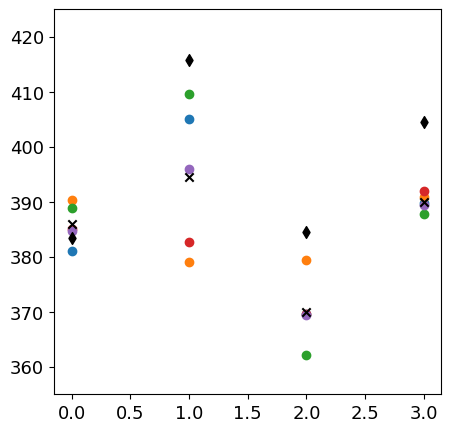

In [ ]:
vals = np.vstack(outputs['test']['finetune']['pred'] + [np.mean(outputs['test']['finetune']['pred'], 0), outputs['test']['finetune']['target'][0]]).T + 273.15
f, ax = plt.subplots(1,1,figsize=(5,5))
for j, i in enumerate([6,7,11,29]):
    a, b, c, d, e, ens, t = vals[i]
    ax.scatter(j, a, color=mpl.cm.tab10(0))
    ax.scatter(j, b, color=mpl.cm.tab10(1))
    ax.scatter(j, c, color=mpl.cm.tab10(2))
    ax.scatter(j, d, color=mpl.cm.tab10(3))
    ax.scatter(j, e, color=mpl.cm.tab10(4))
    ax.scatter(j, t, marker='d', color=[0,0,0])
    ax.scatter(j, ens, marker='x', color=[0,0,0])
ax.set_ylim([355, 425])

#f.savefig('./figs/output.test.support.pdf')

- trained weight change

In [ ]:
gr, tag = 'concat','sing_cg_64.128_6.2'
root_en = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs'
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100'
with open(os.path.join(root_en, gr, tag.replace('sing_',''), '00500.model.torch'),'rb') as f:
    ref = torch.load(f, map_location='cpu')
ref = {k:v.cpu().numpy() for k,v in ref.items() if k.startswith('encoder')}

ws = {}
for model in ['scratch','finetune']:
    ws[model] = {}
    path_m = os.path.join(root, f'{model}_cs')
    for hp in os.listdir(path_m):
        for i in range(5):
            w = torch.load(os.path.join(path_m, hp, gr, tag, f'n_00{i}/best.model.torch'), map_location='cpu')
            w = {k:v.numpy() for k,v in w.items() if k.startswith('encoder')}
            ws[model][f'{hp}_{i}'] = w

In [ ]:
for k, r in ref.items():
    f, axs = plt.subplots(1, 2, figsize=(12, 3), sharex=True, sharey=True)
    f.suptitle(k)
    for i, model in enumerate(['scratch','finetune']):
        diff = []
        for w in ws[model].values():
            diff = np.hstack([diff, (r - w[k]).reshape(-1)])
        axs[i].hist(diff, bins=np.linspace(-1.5,1.5,50))
    

In [ ]:

ws_d = {}
ws_r = {}
root_fi = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/final/'
for model in ['scratch','finetune']:
    ws_d[model] = {}
    ws_r[model] = {}
    for i in range(5):
        p = os.path.join(root_fi, model, f'n_00{i}')
        w = torch.load(os.path.join(p, 'model.torch'), map_location='cpu')
        w1 = {k:v.numpy() for k,v in w.items() if k.startswith('encoder')}
        
        gr, hp = open(os.path.join(p, 'tag.txt')).read().split()[1:]
        hp = hp.replace('sing_','')
        w = torch.load(os.path.join(root_en, gr, hp, '00500.model.torch'), map_location='cpu')
        w0 = {k:v.numpy() for k,v in w.items() if k.startswith('encoder')}

        ws_d[model][i] = {k:v1 - w0[k] for k, v1 in w1.items()}
        ws_r[model][i] = {k:(v1 - w0[k])/w0[k] for k, v1 in w1.items()}

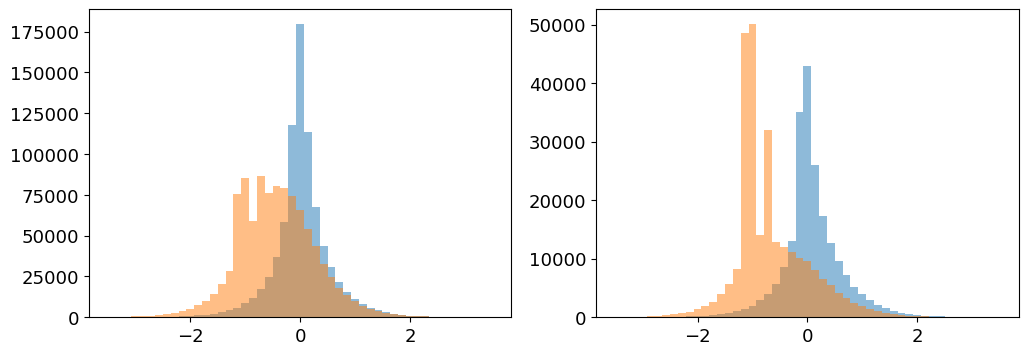

In [ ]:
#f, axss = plt.subplots(5, 2, figsize=(12, 15))
#for axs, model in zip(axss.T, ['scratch','finetune']):
#    for i, ax in enumerate(axs):
#        ax.hist(np.hstack([v.reshape(-1) for v in ws_best[model][i].values()]), bins=np.linspace(-1,1,50))
        
#f, axs = plt.subplots(1,2,figsize=(12, 4), sharey=True)
#for ax, model in zip(axs, ['scratch','finetune']):
#    w = np.hstack([np.hstack([v.reshape(-1) for v in ws_best[model][i].values()]) for i in range(5)])
#    print(np.var(w))
#    ax.hist(np.log10(np.abs(w)), bins=50)#np.linspace(-0.5,0.5,100))
#    
#f, axs = plt.subplots(1,2,figsize=(12, 4), sharey=True)
#for ax, model in zip(axs, ['scratch','finetune']):
#    e = np.hstack([np.hstack([v.reshape(-1) for k,v in ws_best[model][i].items() if 'embed' in k]) for i in range(5)])
#    ax.hist(np.log10(np.abs(e)), bins=50)#np.linspace(-0.5,0.5,100))
#    print(np.var(e))

f, axs = plt.subplots(1,2,figsize=(12, 4), sharex=True)
for  model in ['scratch','finetune']:
    #w = np.hstack([np.hstack([v.reshape(-1) for v in ws_d[model][i].values()]) for i in range(5)])
    #e = np.hstack([np.hstack([v.reshape(-1) for k,v in ws_d[model][i].items() if 'embed' in k]) for i in range(5)])

    #axs[0].hist(np.log10(np.abs(w)), bins=np.linspace(-8, 0, 50), alpha=0.5)
    #axs[1].hist(np.log10(np.abs(e)), bins=np.linspace(-8, 0, 50), alpha=0.5)
    
    w = np.hstack([np.hstack([v.reshape(-1) for v in ws_r[model][i].values()]) for i in range(5)])
    e = np.hstack([np.hstack([v.reshape(-1) for k,v in ws_r[model][i].items() if 'embed' in k]) for i in range(5)])

    axs[0].hist(np.log10(np.abs(w)), bins=np.linspace(-3.5,3.5,50), alpha=0.5)
    axs[1].hist(np.log10(np.abs(e)), bins=np.linspace(-3.5,3.5,50), alpha=0.5)
    

### Statistics

In [ ]:
def get_finals(root, model, fmt='fold_{:1d}_{:s}.pkl'):
    path = os.path.join(root, model)
    outputs = {'metric':[], 'p':[], 't':[]}
    for i in range(5):
        outputs['metric'].append([])
        outputs['p'].append([])
        for ds in ['train','valid','test']:
            out = _parse_data(os.path.join(path, fmt.format(i, ds)))
            outputs['metric'][i].extend([out['r2'], out['mae']])
        outputs['p'][i].append(out['p'])
    outputs['t'] = out['t']
    return {k:np.array(v) for k,v in outputs.items()}

def get_baseline(root, fn):
    pfx = '_'.join(fn.split('.')[:2])
    outputs = {}
    with open(os.path.join(root, fn), 'rb') as f:
        _output = pickle.load(f)
    for k, vs in _output.items():
        output = {'metric':[], 'p':[], 't':vs[0]['test'][0].reshape(-1)}
        for i, v in vs.items():
            output['metric'].append(v['measure'])
            output['p'].append(v['test'][1])
        outputs[f'{pfx}_{k}'] = {k:np.array(v) for k,v in output.items()}
    return outputs

def print_results(data, summary=False):
    fmt = '{:10s} : {:7.3f} {:7.3f} | {:7.3f} {:7.3f} | {:7.3f} {:7.3f}'
    if not summary:    
        for i, metric in enumerate(data['metric']):
            print(fmt.format(f'Fold_{i}', *metric))
        print('-'*80)
    print(fmt.format('AVG', *np.mean(data['metric'], 0)))
    print(fmt.format('STD', *np.std(data['metric'], 0)))

In [ ]:
root = '../outputs/results'
measures = {}
for tune in ['scratch', 'finetune']:
    for model in sorted(os.listdir(f'{root}/{tune}')):
        output = get_finals(os.path.join(root, tune), model)
        measures[f'{tune}_{model}'] = output 
for fn in sorted(os.listdir(os.path.join(root, 'baseline'))):
    _data = get_baseline(os.path.join(root, 'baseline'), fn)
    measures.update(_data)

In [ ]:
for k, output in measures.items():
    if ('ens' in k) or ('gg' in k): continue
    print(k)
    print_results(output, True)

scratch_gr_hp
AVG        :   0.930   3.515 |   0.752  10.619 |  -0.072  11.915
STD        :   0.009   0.410 |   0.052   1.306 |   0.609   2.216
scratch_grgs_hp
AVG        :   0.963   2.738 |   0.742  10.758 |   0.312  10.364
STD        :   0.009   0.308 |   0.045   0.979 |   0.084   0.125
scratch_gs_hp
AVG        :   0.956   3.587 |   0.745  10.506 |   0.314  10.631
STD        :   0.017   0.738 |   0.059   1.107 |   0.083   0.499
finetune_gr_hp
AVG        :   0.962   2.669 |   0.779  10.018 |   0.337  10.362
STD        :   0.014   0.459 |   0.035   1.132 |   0.136   0.854
finetune_grgs_hp
AVG        :   0.976   2.300 |   0.773  10.022 |   0.327  10.686
STD        :   0.007   0.155 |   0.040   0.819 |   0.109   0.626
finetune_gs_hp
AVG        :   0.968   3.083 |   0.736  10.541 |   0.335  10.533
STD        :   0.006   0.394 |   0.055   0.927 |   0.159   0.781
gpr_fp_morgan
AVG        :   0.989   1.501 |  -2.248  45.305 | -16.822  60.031
STD        :   0.005   0.796 |   0.560   2.131 |  

- p-value

In [62]:
from scipy import stats
keys = ['xgb_fp_maccs', 'svr_fp_maccs', 'scratch_gr_hp', 'finetune_gr_hp', 'finetune_grgs_hp']
# R2
for key_1 in keys[1:]:
    s = ''
    for key_2 in keys[:-1]:
        v = stats.ttest_ind(measures[key_1]['metric'].T[2], measures[key_2]['metric'].T[2], equal_var=False)
        s += f'{v.pvalue:10.5f}'
    print(s)

print()
# MAE
for key_1 in keys[1:]:
    s = ''
    for key_2 in keys[:-1]:
        v = stats.ttest_ind(measures[key_1]['metric'].T[3], measures[key_2]['metric'].T[3], equal_var=False)
        s += f'{v.pvalue:10.5f}'
    print(s)



   0.79196   1.00000   0.37025   0.14224
   0.39283   0.37025   1.00000   0.41949
   0.08248   0.14224   0.41949   1.00000
   0.12179   0.17439   0.52835   0.84957

   0.63422   1.00000   0.21543   0.05769
   0.41084   0.21543   1.00000   0.50680
   0.13213   0.05769   0.50680   1.00000
   0.09692   0.03720   0.46506   0.99526


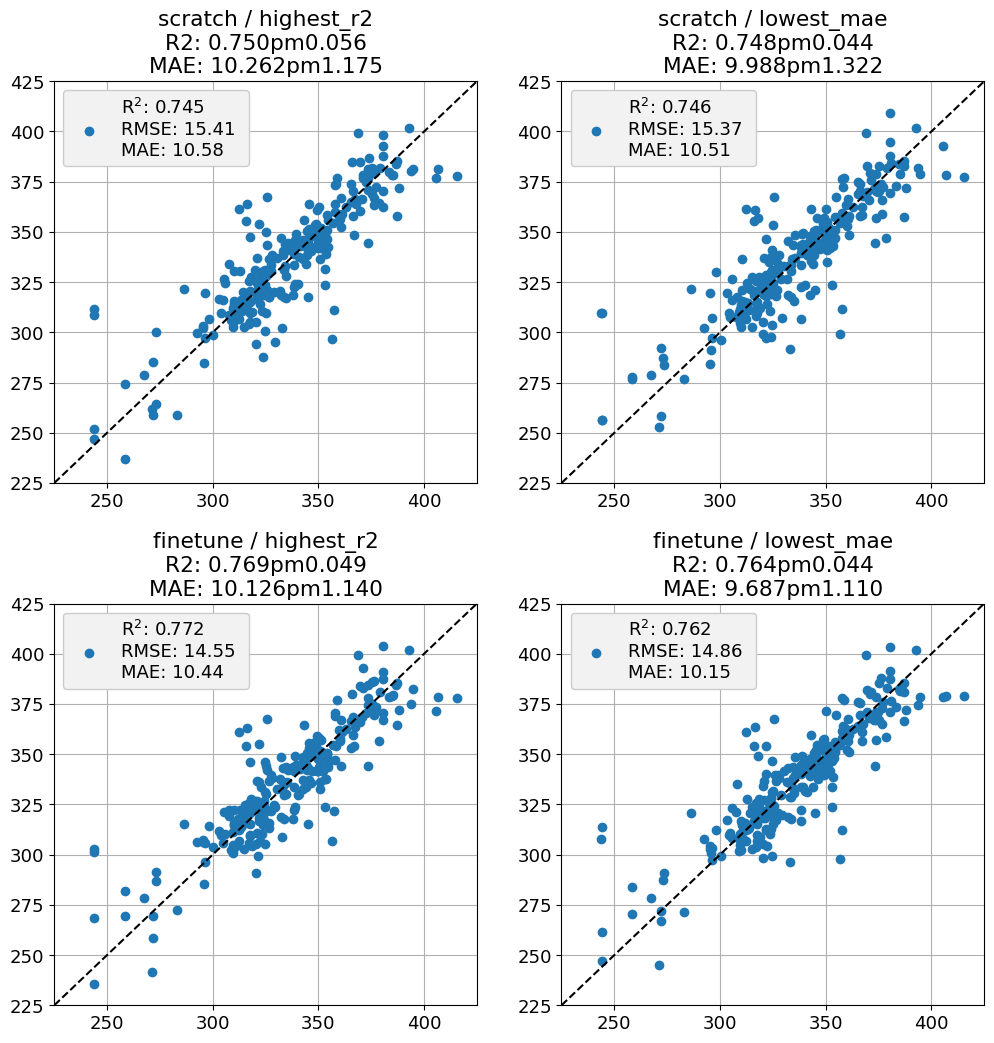

In [88]:
f, axss = plt.subplots(2,2,figsize=(12, 12))
for axs, model in zip(axss, ['scratch','finetune']):
    i_r2 = np.mean(valid_r2s[model], 0).argmax()
    i_mae = np.mean(valid_maes[model], 0).argmin()
    y1 = np.hstack([pred_bf[j]['valid'][model][i_r2].reshape(-1) for j in range(5)]) + 273.15
    y2 = np.hstack([pred_bf[j]['valid'][model][i_mae].reshape(-1) for j in range(5)]) + 273.15
    x = np.hstack([tgts_bf[j]['valid'].reshape(-1) for j in range(5)]) + 273.15
    plot_scatter(axs[0], x, y1, xrange=[225, 425])
    plot_scatter(axs[1], x, y2, xrange=[225, 425])
    axs[0].set_title('{} / highest_r2\nR2: {:.3f}pm{:.3f}\nMAE: {:.3f}pm{:.3f}'.format(model, np.mean(valid_r2s[model], 0)[i_r2], np.std(valid_r2s[model], 0)[i_r2], np.mean(valid_maes[model], 0)[i_r2], np.std(valid_maes[model], 0)[i_r2]))
    axs[1].set_title('{} / lowest_mae\nR2: {:.3f}pm{:.3f}\nMAE: {:.3f}pm{:.3f}'.format(model, np.mean(valid_r2s[model], 0)[i_mae], np.std(valid_r2s[model], 0)[i_mae], np.mean(valid_maes[model], 0)[i_mae], np.std(valid_maes[model], 0)[i_mae]))
f.subplots_adjust(hspace=0.3)
f.savefig('./figs/output.valid.cv.pdf')

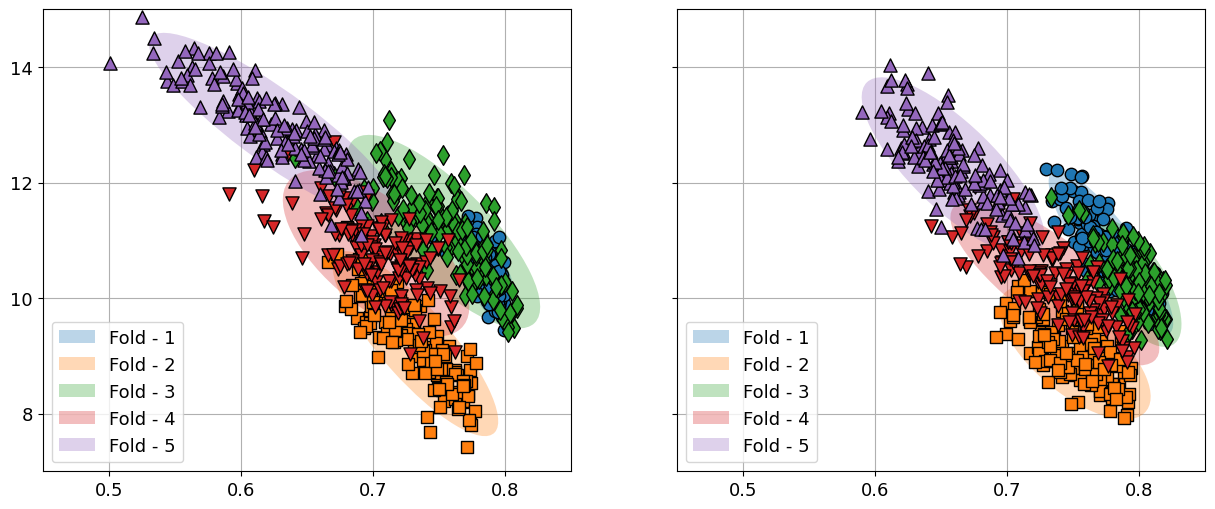

In [9]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def conf_elipse(ax, x, y, std=5, **kwargs):
    cov = np.cov(x, y)
    cor = np.corrcoef(r[i],m[i])[0,1]
    ell_rad_x = np.sqrt(1 + cor)
    ell_rad_y = np.sqrt(1 - cor)
    ell = Ellipse((0,0), width=ell_rad_x*2, height=ell_rad_y*2, **kwargs)
    scale_x = np.sqrt(cov[0,0] * std)
    scale_y = np.sqrt(cov[1,1] * std)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ell.set_transform(transf + ax.transData)
    ax.add_patch(ell)
    return
    
f, axs = plt.subplots(1,2,figsize=(15,6), sharex=True, sharey=True)
markers = ['o','s','d','v','^']
sizes = [80, 80, 100, 90, 90]
for (model, r), m, ax in zip(valid_r2s.items(), valid_maes.values(), axs):
    for i in range(5):
        ax.scatter(r[i], m[i], marker=markers[i], s=sizes[i], edgecolors=[0,0,0], zorder=99)
        conf_elipse(ax, r[i], m[i], facecolor=mpl.cm.tab10(i), alpha=0.3, zorder=80, label=f'Fold - {i+1}')
    ax.set_xlim([0.45, 0.85])
    ax.set_ylim([7, 15])
    ax.set_yticks([8, 10, 12, 14])
    ax.set_xticks([0.5 ,0.6, 0.7, 0.8])
    ax.grid('on')
    ax.legend(loc='lower left')
#f.savefig('./output.cv_performance.pdf')
#    plt.plot(np.linspace(0.5, 1, 20), np.linspace(1, 0.5, 20) - 0.25)


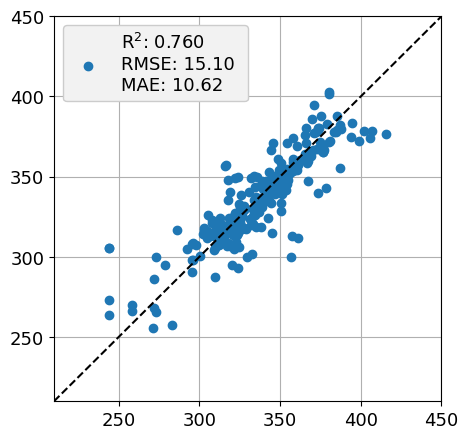

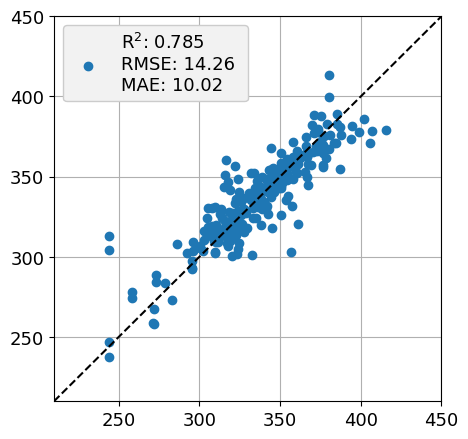

In [10]:
for model in ['scratch','finetune']:
    f, ax = plt.subplots(1,1,figsize=(5,5))
    j = np.argmax(valid_r2s[model].mean(0))
    x1 = np.hstack([tgts_bf[i]['valid'] for i in range(5)])
    y = np.hstack([pred_bf[i]['valid'][model][j].astype(float) for i in range(5)])
    plot_scatter(ax, x1+273.15, y + 273.15, xrange=[210, 450])
    x = np.linspace(0,500,100)
    #ax.plot(x, x+std)
    #ax.plot(x, x-std)
#    if model == 'scratch':
#        f.savefig('./output.sc.test.pdf')
#    else:
#        f.savefig('./output.ft.test.pdf')

- fingerprint 간 거리 활용
- 데이터의 공통첨을 찾기. 
- 각 fold별로 잘 맞추고 못 맞추는 것들이 구분이 되도록.
- 모노머별로? 특정 모노머의 포함 여부를 체크?

In [180]:
from src.model.base import GraphNet
from src.utils.data import CrossValidation
from src.utils.dataset import BaseDataset, basic_collate_fn
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import TanimotoSimilarity, DiceSimilarity

df1 = pd.read_csv('../data/fpolymers.tg.train.csv')
df2 = pd.read_csv('../data/fpolymers.tg.test.csv')

col_s = [f'SMILES_{x}' for x in 'ABCDE']
col_w = [f'FR_{x}' for x in 'ABCDE']

ss1 = df1[col_s].values.reshape(-1)
ws1 = df1[col_w].fillna(0).values.reshape(-1)
ss1[ws1 == 0] = ''
ss1 = ss1.reshape(-1,5)
ws1 = ws1.reshape(-1,5)
ws1 /= ws1.sum(1).reshape(-1,1)

ss2 = df2[col_s].values.reshape(-1)
ws2 = df2[col_w].fillna(0).values.reshape(-1)
ss2[ws2 == 0] = ''
ss2 = ss2.reshape(-1,5)
ws2 = ws2.reshape(-1,5)
ws2 /= ws2.sum(1).reshape(-1,1)

ss = np.vstack([ss1, ss2])
ws = np.vstack([ws1, ws2])
uss = [s for s in sorted(np.unique(ss.reshape(-1)))[1:]]
usfs = [s for s in uss if 'F' in s]
uscs = [s for s in uss if 'F' not in s] 

mapper = {'':''}
mapper.update({s:f'f{i:02d}' for i,s in enumerate(usfs)})
mapper.update({s:f'c{i:02d}' for i,s in enumerate(uscs)})
_mapper = {v:k for k,v in mapper.items()}

qs1 = np.array([' '.join([mapper[s] for s in _ss if s != '']) for _ss in ss1])
qw3s1 = np.array([' '.join([f'{mapper[s]} {w:.3f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss1, ws1)])
qw2s1 = np.array([' '.join([f'{mapper[s]} {w:.2f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss1, ws1)])

qs2 = np.array([' '.join([mapper[s] for s in _ss if s != '']) for _ss in ss2])
qw3s2 = np.array([' '.join([f'{mapper[s]} {w:.3f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss2, ws2)])
qw2s2 = np.array([' '.join([f'{mapper[s]} {w:.2f}' for s, w in zip(_ss, _ws) if s != '']) for _ss, _ws in zip(ss2, ws2)])

model_preds = {}
for tune in ['scratch','finetune']:
    model_preds[tune] = {'train':[], 'valid':[], 'test':[]}
    for i in range(5):
        path = f'../outputs/{tune}/all_ens/fold_0{i}'
        with open(os.path.join(path, 'test.pkl'), 'rb') as f:
            ids, tgts, preds = pickle.load(f)
        model_preds[tune]['test'].append(preds.reshape(-1))

In [196]:
for fs in sorted(np.unique(ss2.reshape(-1))[1:]):
    if 'F' not in fs: continue
    print(np.sum(np.sum(ss1 == fs, 1) != 0), '\t', fs)

18 	 C=C(C)C(=O)OC(COCC(F)(F)C(F)(F)F)COCC(F)(F)C(F)(F)F
12 	 CC(=C)C(=O)OC(C(F)(F)F)C(F)(F)F
50 	 CC(=C)C(=O)OCC(C(F)(F)F)(F)F
9 	 CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)F
6 	 CC(=C)C(=O)OCC(F)(F)C(F)F
7 	 CC(=C)C(=O)OCC(F)(F)F
7 	 CC(=C)C(=O)OCC(F)(F)[C@H](F)C(F)(F)F
26 	 FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C
6 	 FC(F)(F)C(OC(=O)C=C)C(F)(F)F
12 	 FC(F)(F)COC(=O)C=C


In [205]:
cv = CrossValidation(5, n_data=df1.shape[0], seed=100, return_index=True)
def get_count_from_fold(s):
    global ss1, ss2, cv
    _smask = (ss1 == s).sum(1).astype(bool)
    trs = []
    for i in range(5):
        trs.append(_smask[cv[i][0]].sum())
    test = (ss2 == s).sum()
    if test == 0 or test > 10:
        return
    if np.sum(_smask) > 3: return
    print('SMILES: ',s)
    print(' '.join([f'{c:7d}' for c in trs]), f'      / {np.sum(_smask):5d}  {test:5d} / ')
    for i in np.where((ss2 == s).sum(1))[0]:
        t = df2.TG[i] + 273.15
        print(f'No.{i:3d} / {t:7.2f}')
        q1, q2, q3 = qs2[i], qw2s2[i], qw3s2[i]
        for tune in ['scratch','finetune']:
            val = [model_preds[tune]['test'][j][i].astype(float) for j in range(5)]
            val.append(np.mean(val))
            print(' '.join(['{:7.2f} ({:6.2f})'.format(v+273.15, v +273.15 - t) for v in val]))
    print()
    
#for s in usfs:
#    get_count_from_fold(s)

for s in uscs:
    get_count_from_fold(s)


SMILES:  CC(=C)C(=O)OC1CC2CC1C3C2CCC3
      1       0       1       1       1       /     1      3 / 
No.  7 /  415.82
 383.63 (-32.19)  366.27 (-49.55)  403.34 (-12.48)  381.59 (-34.23)  395.62 (-20.20)  386.09 (-29.73)
 405.14 (-10.68)  379.06 (-36.76)  409.68 ( -6.14)  382.67 (-33.15)  395.96 (-19.86)  394.50 (-21.32)
No.  8 /  374.59
 381.62 (  7.03)  380.57 (  5.98)  386.01 ( 11.42)  395.80 ( 21.21)  392.48 ( 17.89)  387.30 ( 12.71)
 382.71 (  8.12)  376.82 (  2.23)  388.42 ( 13.83)  385.75 ( 11.16)  388.85 ( 14.26)  384.51 (  9.92)
No. 31 /  351.83
 375.52 ( 23.69)  355.27 (  3.44)  372.66 ( 20.83)  328.02 (-23.81)  365.82 ( 13.99)  359.46 (  7.63)
 379.08 ( 27.25)  363.77 ( 11.94)  374.99 ( 23.16)  357.17 (  5.34)  366.63 ( 14.80)  368.33 ( 16.50)

SMILES:  CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C
      0       0       0       0       0       /     0      4 / 
No.  4 /  408.95
 366.93 (-42.02)  370.20 (-38.75)  392.25 (-16.70)  387.10 (-21.85)  377.00 (-31.95)  378.69 (-30.26)
 393.34 (-1

In [165]:
cv = CrossValidation(5, n_data=df1.shape[0], seed=100, return_index=True)
for i, (s_, t) in enumerate(zip(ss2, df2.TG.values)):
#    if i not in [5, 30, 34]: continue
    print(f'No.{i:3d} /','/'.join([f'    F_{j} ' for j in range(5)]),f'/ {t:6.2f}')
    for j, s in enumerate(s_):
        if s == '':
            print(f'Mon.{j}  /','/'.join(['    --- ']*5))
        else:
            print(f'Mon.{j}  /','/'.join([f'    {(ss1[cv[k][0]] == s).sum():3d} ' for k in range(5)]))
    for mdn, tune in zip(['SC','FT'],['scratch','finetune']):
        p_ = [model_preds[tune]['test'][j][i] for j in range(5)]
        p_.extend([np.mean(p_), np.mean(p_) - t])
        print(f'  {mdn}   /','/'.join([f' {p:6.2f} ' for p in p_]))
    print()

No.  0 /     F_0 /    F_1 /    F_2 /    F_3 /    F_4  /  89.28
Mon.0  /       4 /      6 /      5 /      4 /      5 
Mon.1  /      88 /     89 /     85 /     88 /     94 
Mon.2  /     128 /    127 /    131 /    129 /    129 
Mon.3  /      98 /    100 /     93 /     95 /     94 
Mon.4  /     156 /    155 /    157 /    157 /    155 
  SC   /   84.10 /  86.27 /  80.89 /  76.25 /  82.00 /  81.90 /  -7.38 
  FT   /   85.67 /  75.49 /  82.85 /  81.94 /  80.48 /  81.28 /  -8.00 

No.  1 /     F_0 /    F_1 /    F_2 /    F_3 /    F_4  /  82.92
Mon.0  /      43 /     40 /     40 /     38 /     39 
Mon.1  /      88 /     89 /     85 /     88 /     94 
Mon.2  /     128 /    127 /    131 /    129 /    129 
Mon.3  /      98 /    100 /     93 /     95 /     94 
Mon.4  /     156 /    155 /    157 /    157 /    155 
  SC   /   84.58 /  85.70 /  80.93 /  76.75 /  81.42 /  81.88 /  -1.04 
  FT   /   84.26 /  77.74 /  80.03 /  81.48 /  83.81 /  81.46 /  -1.46 

No.  2 /     F_0 /    F_1 /    F_2 /    F_3 

In [172]:
from rdkit import Chem
from rdkit.Chem import Draw

smiles = ['C=C(C(=O)O)C(F)(F)F', 'CC1(C)[C@H]2CC[C@]1(C)C(C2)OC(=O)C=C', 'CC1C2CC(C1(C)C)CC2C3CCCC(C3)OC(=O)C=C', 'CCCOC(=O)C(C)=C', ]
fig = Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in smiles], molsPerRow=1, subImgSize=(500,500), useSVG=True)

#with open('extra_mol.svg','w') as f:
#    f.write(fig.data)

- 처음보는 monomer가 포함된 데이터에 대한 예측 성능

['-42.02', '-38.75', '-16.70', '-21.85', '-31.95', '-30.26']
['-15.61', '-33.10', ' -9.76', '-16.91', '-17.50', '-18.57']
[' 25.13', ' 28.34', ' -2.69', ' -7.85', ' -0.99', '  8.39']
[' 20.65', ' 14.08', '  8.66', '  5.99', ' -1.58', '  9.56']
['-31.39', ' -9.31', '  2.55', '-25.76', '-15.08', '-15.80']
[' 18.58', ' -5.62', ' 10.45', ' -2.93', ' -8.63', '  2.37']


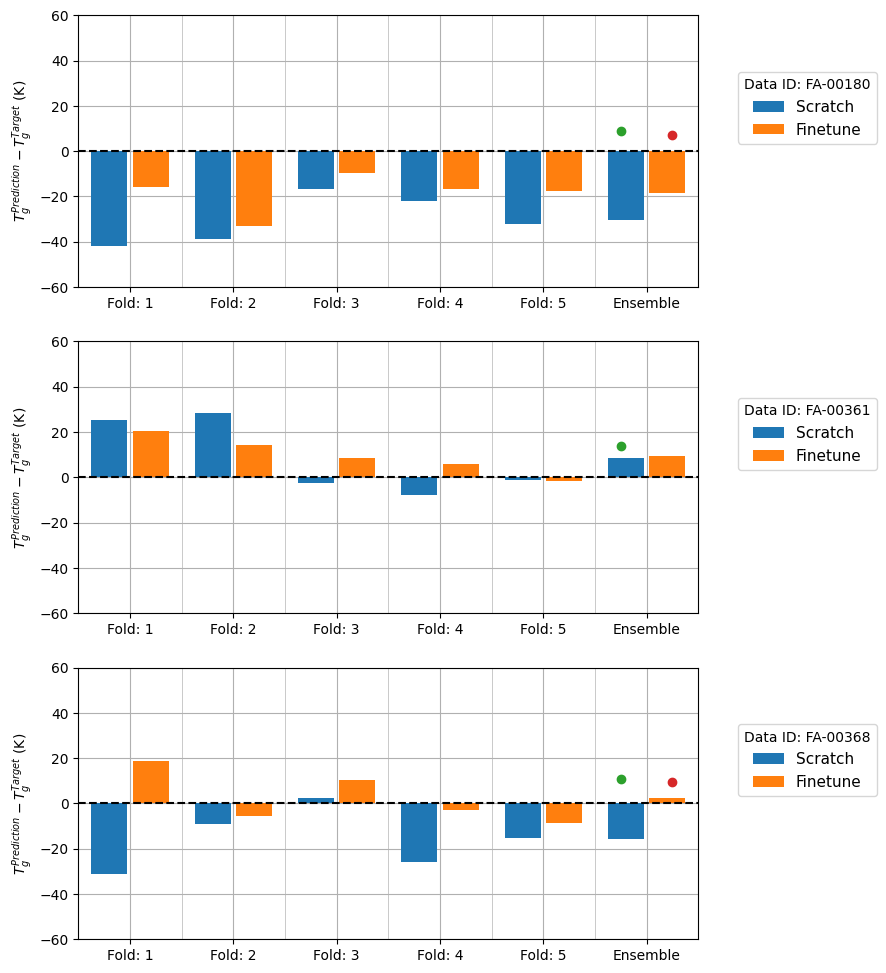

In [212]:
ids = [4, 32, 34]
f, axs = plt.subplots(len(ids), 1,figsize=(8, 4*len(ids)))
for i, ax in zip(ids, axs):
    t = df2.TG[i]
    p1 = np.array(model_preds['scratch']['test'])[:, i]
    p2 = np.array(model_preds['finetune']['test'])[:, i]
    p1 = np.hstack([p1, p1.mean()])
    p2 = np.hstack([p2, p2.mean()])
    ax.bar(np.linspace(1,11,6)-0.4, p1 - t, width=0.7, zorder=10, label='Scratch')
    ax.bar(np.linspace(1,11,6)+0.4, p2 - t, width=0.7, zorder=10, label='Finetune')
    ax.scatter(10.5, np.std(p1))
    ax.scatter(11.5, np.std(p2))
    print([f'{v:6.2f}' for v in p1 - t])
    print([f'{v:6.2f}' for v in p2 - t])
    ax.axhline(0, ls='--', color=[0,0,0], zorder=99)
    [ax.axvline(i*2, color=[0.7, 0.7, 0.7], lw=0.5) for i in range(1,6)]
    ax.grid('on')
    ax.set_xticks([i*2+1 for i in range(6)],labels=[f'Fold: {i}' for i in range(1,6)] + ['Ensemble'])
    ax.set_ylim([-60,60])
    ax.set_xlim([0,12])
    if i != 36:
        ax.legend(loc='lower right', title=f'Data ID: {df2.ID[i]}', fontsize=11, bbox_to_anchor=(1.3,0.5))
    else:
        ax.legend(loc='upper right', title=f'Data ID: {df2.ID[i]}', fontsize=11, bbox_to_anchor=(1.3,0.5))
    ax.set_ylabel('$T_g^{Prediction}-T_g^{Target}$ (K)')
f.savefig('../../figs/output.test.error_of_unknown_monomers.pdf')

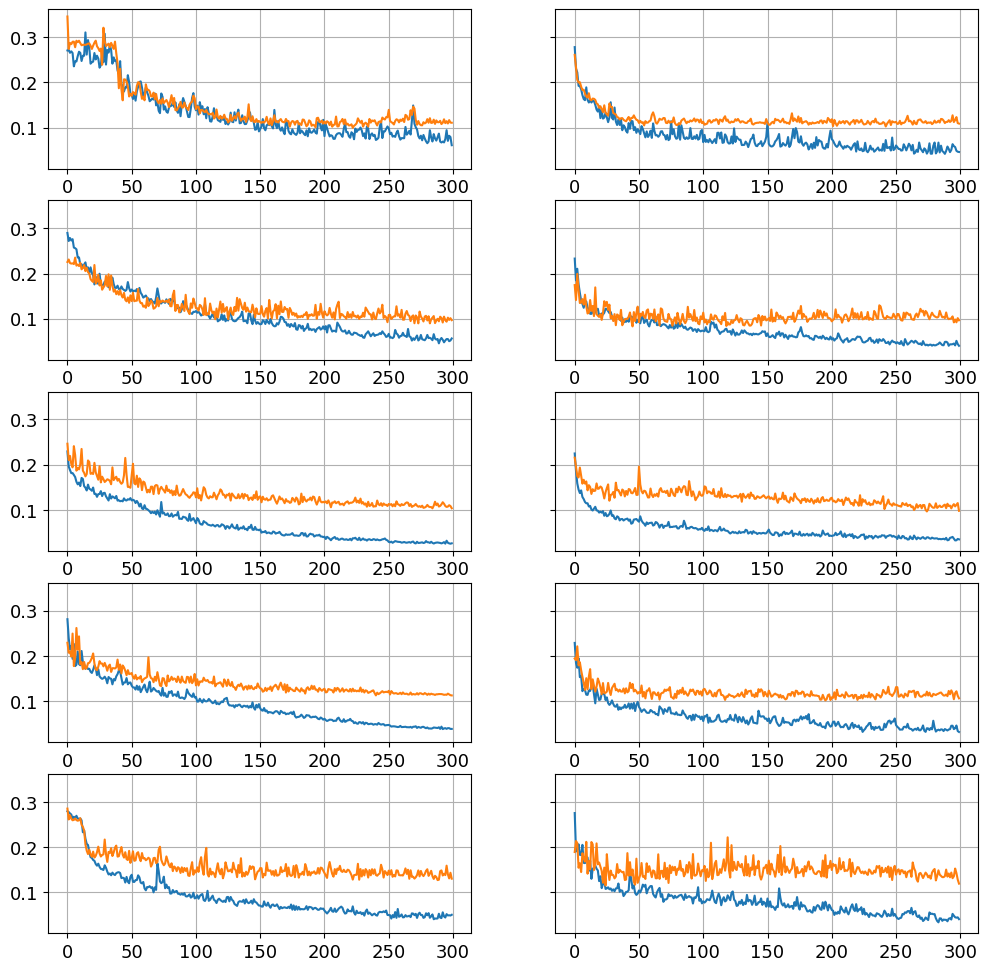

In [19]:
f, axs = plt.subplots(5,2,figsize=(12,12), sharey=True)

for tune in ['scratch','finetune']:
    for i in range(5):
        path = f'../outputs/models/{tune}/all_ens/fold_{i}/loss.txt'
        t, v = np.loadtxt(path)
        axs[i,int(tune == 'finetune')].plot(t)
        axs[i,int(tune == 'finetune')].plot(v)
for ax in axs.reshape(-1): ax.grid('on')

# TL / Ensemble 효과 확인

## loading data

In [1]:
import os, sys, json, pickle, torch, gc
sys.path.append('..')
from src.model.modules import SingleEncoderModel
from src.utils.dataset import FPolyDatasetV2, FPolyDatasetV3, collate_fn
from src.utils.data import DataScaler
import pandas as pd
import numpy as np

train_ds = FPolyDatasetV2()
train_ds.generate('../data/fpolymers.tg.train.csv')
train_feat, train_tgt, train_ids = collate_fn(train_ds)

test_ds = FPolyDatasetV2()
test_ds.generate('../data/fpolymers.tg.test.csv')
test_feat, test_tgt, test_ids = collate_fn(test_ds)

exp_ds = FPolyDatasetV2()
exp_ds.generate('/home/jhyang/WORKSPACES/DATA/molecule/fpolymer/fpolymers_20231215_exp.csv', col_id='ID_screen')
exp_feat, exp_tgt, exp_ids = collate_fn(exp_ds)

screen_ds = FPolyDatasetV2()
screen_ds.generate('../data/fpolymers.tg.screen.csv')
screen_feat, screen_tgt, screen_ids = collate_fn(screen_ds)

df = pd.concat([
    pd.read_csv('../data/fpolymers.tg.screen.csv'),
    pd.read_csv('../data/fpolymers.tg.train.csv'),
    pd.read_csv('../data/fpolymers.tg.test.csv'),
])
smiles = sorted(np.unique(df[[f'SMILES_{x}' for x in 'ABCDE']].fillna('').values.reshape(-1)))[1:]
dfv3 = pd.DataFrame(smiles, columns=['smiles'])
dfv3['fr'] = 1
dfv3['ID'] = dfv3.index
ds_monomer = FPolyDatasetV3()
ds_monomer.generate(dfv3, col_smiles=['smiles'], col_weights=['fr'], col_target=['ID'])
monomer_feat, _, _ = collate_fn(ds_monomer)

In [3]:
scaler = DataScaler()
outputs = {'target':{
    'train': train_tgt.cpu().numpy().reshape(-1),
    'test': test_tgt.cpu().numpy().reshape(-1),
    'screen': screen_tgt.cpu().numpy().reshape(-1),
    'exp': exp_tgt.cpu().numpy().reshape(-1),
}}
for tune in ['scratch','finetune']:
    outputs[tune] = {}
    for i in range(5):
        outputs[tune][i] = {}
        path = f'../outputs/{tune}/all_ens/fold_0{i}'
        model = SingleEncoderModel(**json.load(open(os.path.join(path, 'param.json'))))
        model.load(os.path.join(path, 'model.torch'))
        scaler.load(path)
        print(tune, i)
        with torch.no_grad():
            train_pred_ = model(train_feat)
            train_pred = scaler.restore(train_pred_.cpu()).numpy()
            train_embd = model._embd.cpu().numpy()
            del train_pred_
            gc.collect()
            
            test_pred_ = model(test_feat)
            test_pred = scaler.restore(test_pred_.cpu()).numpy()
            test_embd = model._embd.cpu().numpy()
            del test_pred_
            gc.collect()

            screen_pred_ = model(screen_feat)
            screen_pred = scaler.restore(screen_pred_.cpu()).numpy()
            screen_embd = model._embd.cpu().numpy()
            del screen_pred_
            gc.collect()

            exp_pred_ = model(exp_feat)
            exp_pred = scaler.restore(exp_pred_.cpu()).numpy()
            exp_embd = model._embd.cpu().numpy()
            del exp_pred_
            gc.collect()

            _ = model(monomer_feat)
            monomer_embd = model._embd.cpu().numpy()

        outputs[tune][i] = {
            'embedding':{
                'train':train_embd, 
                'test':test_embd, 
                'exp':exp_embd, 
                'monomer':monomer_embd,
            },
            'prediction':{
                'train':train_pred.reshape(-1),
                'test':test_pred.reshape(-1),
                'screen':screen_pred.reshape(-1),
                'exp':exp_pred.reshape(-1),
            },
        }

scratch 0
scratch 1
scratch 2
scratch 3
scratch 4
finetune 0
finetune 1
finetune 2
finetune 3
finetune 4


In [102]:
outputs['finetune'][3]['prediction']

{'train': array([ 83.04112   ,  82.21455   ,  89.341125  ,  78.43864   ,
         62.837162  ,  74.60261   ,  58.03154   ,  44.85489   ,
         75.72364   ,  61.82218   ,  46.15198   ,  71.55081   ,
         46.14955   ,  31.943058  ,  69.91575   ,  59.486115  ,
         49.124638  ,  73.334305  ,  50.059975  ,  36.85907   ,
         66.0065    ,  51.8474    ,  31.91805   ,  70.02087   ,
         48.247364  ,  29.278934  ,  72.836296  ,  66.44748   ,
         75.964554  ,  67.80309   ,  82.11064   ,  74.34047   ,
         61.836624  ,  76.98219   ,  65.09491   ,  53.505516  ,
         69.223885  ,  75.43454   ,  71.27131   ,  77.59431   ,
         62.243126  ,  52.56056   ,  71.39043   ,  55.18975   ,
        101.96672   , 101.17137   ,  96.675735  ,  29.94701   ,
         47.141647  ,  83.69061   ,  93.5374    , 102.105865  ,
         64.976425  ,  78.05801   ,  98.88956   , 124.707184  ,
         87.26603   , 104.20148   , 101.18375   , 113.23665   ,
         42.386864  ,  60.4027 

In [103]:
with open('../dump/output.pkl','wb') as f:
    pickle.dump(outputs, f)

## drawing

In [ ]:
with open('../dump/output.pkl','rb') as f:
    outputs = pickle.load(f)

### embeddings

- useless

In [12]:
from sklearn.manifold import TSNE
tvecs = {}
for tune in ['scratch','finetune']:
    tvecs[tune] = {}
    for i in range(5):
        tsne = TSNE(perplexity=20)
        tvec1 = tsne.fit_transform(np.vstack([outputs[tune][i]['embedding']['train'], outputs[tune][i]['embedding']['test']]))
        tvec2 = tsne.fit_transform(outputs[tune][i]['embedding']['monomer'])
        tvecs[tune][i] = [tvec1, tvec2]

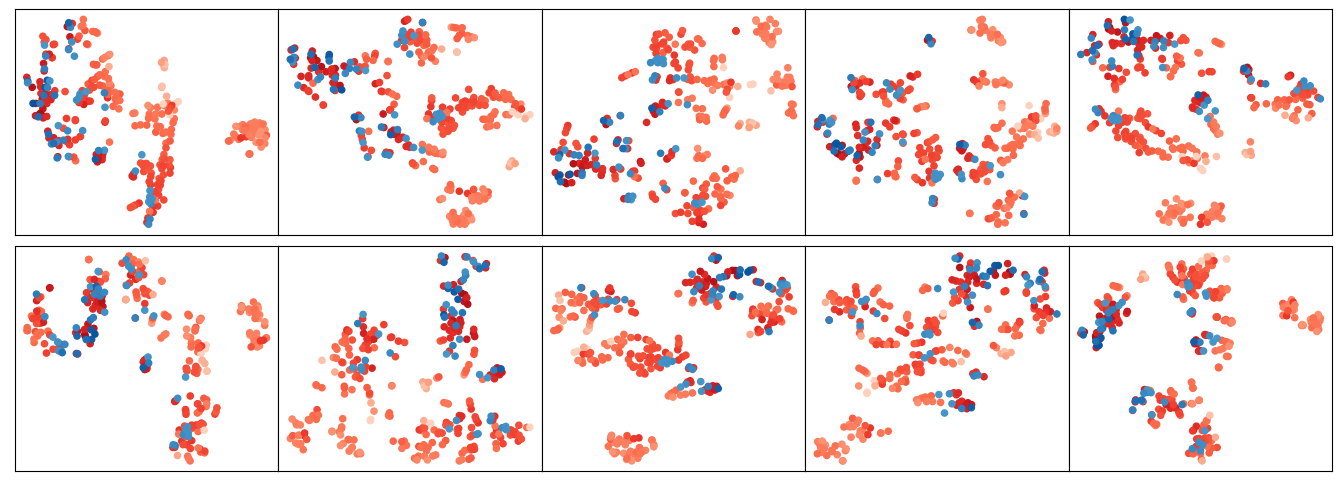

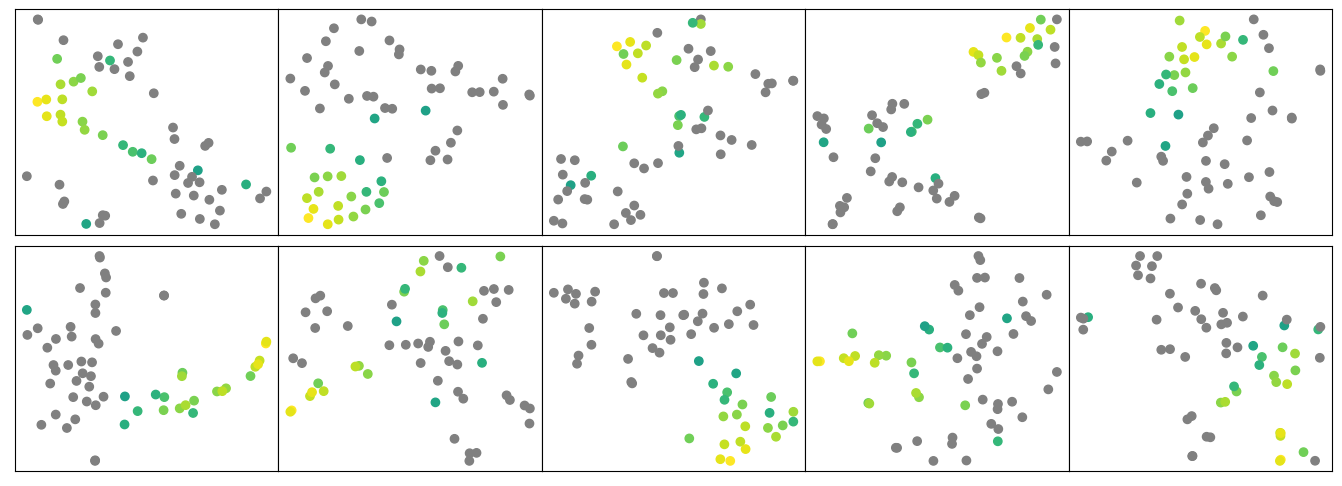

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from rdkit.Chem import MolFromSmiles, Descriptors

viridis_grey = mpl.cm.viridis
viridis_grey.set_under([0.5, 0.5, 0.5])

tg = np.hstack([train_tgt.reshape(-1), test_tgt.reshape(-1)]) + 273.15
isF = np.array([np.sum('F' == np.array(list(s)))/len(s) for s in smiles])
mw = np.array([Descriptors.MolWt(MolFromSmiles(s)) for s in smiles])
f1, axs1 = plt.subplots(2, 5, figsize=(17, 6))
f2, axs2 = plt.subplots(2, 5, figsize=(17, 6))
for ax1, ax2, tune in zip(axs1, axs2, ['scratch','finetune']):
    for i in range(5):
        tvec1, tvec2 = tvecs[tune][i]
        ax1[i].scatter(*tvec1[:245].T, c=tg[:245], vmin=200, vmax=450, s=20, cmap='Reds')
        ax1[i].scatter(*tvec1[245:].T, c=tg[245:], vmin=200, vmax=450, s=20, cmap='Blues')
#        ax2[i].scatter(*tvec2.T, c=mw)
        ax2[i].scatter(*tvec2.T, c=isF, vmin=1e-5, cmap=viridis_grey)
for ax in np.vstack([axs1, axs2]).reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
for f in [f1, f2]:
    f.subplots_adjust(wspace=0, hspace=0.05)

### Tg dist of screening data

- useless

In [21]:
from scipy.stats import gaussian_kde

x = np.linspace(250, 450, 3000)
ys = {}
for tune in ['scratch','finetune']:
    ys[tune] = []
    for i in range(5):
        g = gaussian_kde(outputs[tune][i]['prediction']['screen'].reshape(-1) + 273.15, 0.05)
        ys[tune].append(g(x))
    g = gaussian_kde(np.mean([outputs[tune][i]['prediction']['screen'].reshape(-1) for i in range(5)], 0) + 273.15, 0.05)
    ys[tune].append(g(x))

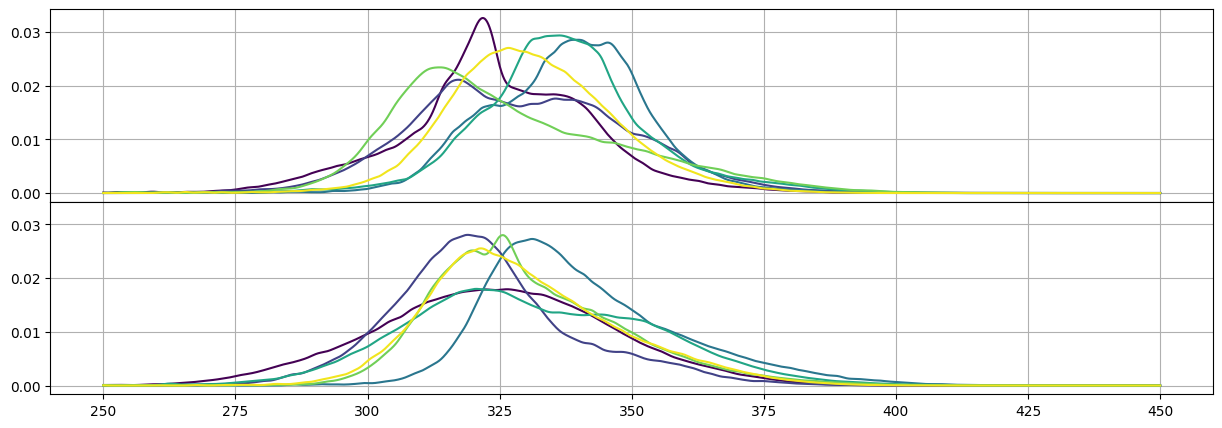

In [24]:
f, axs = plt.subplots(2,1,figsize=(15,5), sharex=True, sharey=True)
for ax, y in zip(axs, ys.values()):
    for i in range(6):
        ax.plot(x, y[i], color=mpl.cm.viridis(i/5.1))
    ax.grid()
f.subplots_adjust(hspace=0)

### exp valid results

In [63]:
outputs[tune][i]['prediction']['exp'] + 273.15, outputs['target']['exp']

(array([316.20667, 312.37698, 313.41043, 289.5186 , 322.6799 , 314.14563,
        309.53174, 329.86343, 321.25363, 368.68427, 385.17734, 330.809  ,
        385.2532 , 374.22235, 390.65308, 321.75848, 333.7633 , 333.4243 ,
        322.93494, 334.96494, 358.0904 , 355.5231 , 351.39105, 325.3053 ,
        329.9819 , 346.93008, 324.34213, 336.2118 , 331.09927, 340.11526,
        318.6073 , 324.21948, 349.77655, 365.67422, 325.3111 , 327.8953 ,
        333.37567, 320.93317, 341.89316, 319.29556, 392.75952, 403.88626,
        395.45288, 381.9837 , 383.245  , 376.37067, 380.9995 , 375.70352],
       dtype=float32),
 array([ 46.08,  32.82,  31.18,  46.93,  56.01,  34.72,  35.76,  51.08,
         46.14, 132.53, 150.05,  96.81, 154.93, 136.79, 118.95,  79.89,
         60.8 ,  82.22,  88.1 ,  67.24, 120.97,  82.45,  96.17,  75.14,
         44.37, 107.79,  65.12, 100.45,  69.25,  81.01,  66.51,  50.78,
         83.46, 108.78,  70.17,  53.35,  40.53,  43.32,  69.39,  64.68,
        172.99, 135.45, 

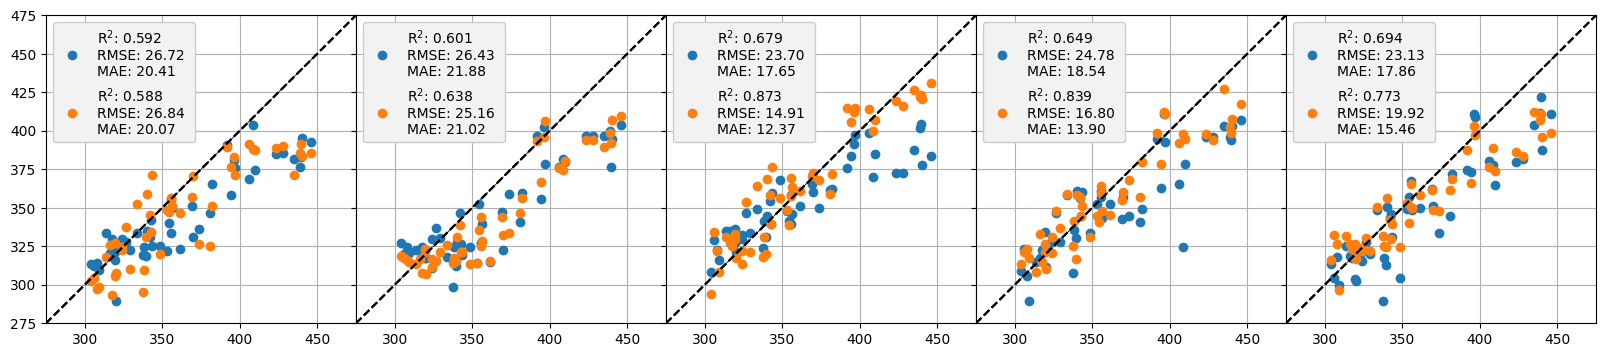

In [65]:
import sys
sys.path.append('..')
from src.utils.visualization import plot_scatter

f1, axs1 = plt.subplots(1,5,figsize=(20,4), sharex=True, sharey=True)
for tune in ['scratch','finetune']:
    for i in range(5):
        plot_scatter(axs1[i], target=outputs['target']['exp'] + 273.15, pred=outputs[tune][i]['prediction']['exp'] + 273.15, xrange=[275, 475])
for ax in axs1:
    ax.grid()
    ax.plot([300, 450], [300, 450], ls='--', color=[0,0,0], lw=0.6)
f1.subplots_adjust(wspace=0)

21
    0.2589    24.7604     0.9015 	 0.540 x + 159.458
    0.5778    19.2067     0.9212 	 0.545 x + 167.212


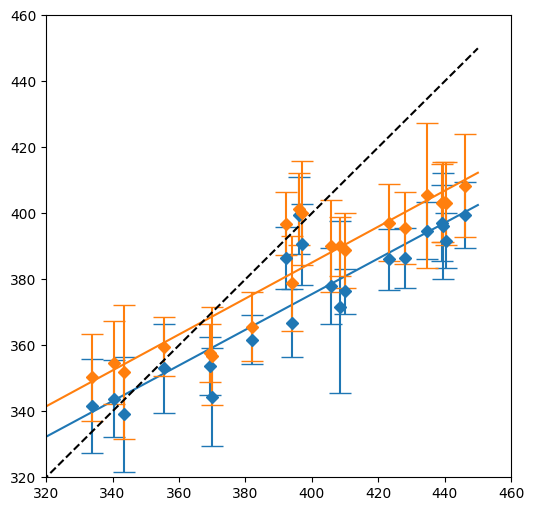

In [120]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import numpy as np

LR = LinearRegression()

f, ax = plt.subplots(1,1,figsize=(6,6))
y = np.mean([outputs['finetune'][i]['prediction']['exp'] for i in range(5)], 0) + 273.15
m = y > 350
print(np.sum(m))
x = outputs['target']['exp'][m] + 273.15

for j, tune in enumerate(['scratch','finetune']):
    y = np.mean([outputs[tune][i]['prediction']['exp'][m] for i in range(5)], 0) + 273.15
    yerr = np.std([outputs[tune][i]['prediction']['exp'][m] for i in range(5)], 0)
    LR.fit(x.reshape(-1,1), y.reshape(-1,1))
    y_lr = LR.predict([[300], [450]]).reshape(-1)
    a, b = LR.coef_[0][0], LR.predict([[0]])[0][0]
    ax.errorbar(x, y, yerr=yerr, fmt='D', capsize=8, color=mpl.cm.tab10(j))
    ax.plot([300, 450], y_lr, color=mpl.cm.tab10(j))
    print('{:10.4f} {:10.4f} {:10.4f} \t {:.3f} x + {:.3f}'.format(r2_score(x, y), mean_absolute_error(x, y), np.corrcoef(x, y)[0,1], a, b))
ax.plot([300, 450], [300, 450], '--k')
ax.set_xlim([320, 460])
ax.set_ylim([320, 460])
f.savefig('../../figs/output.exp.both.pdf')

42
    0.5344     9.5668     0.7639 	 0.658 x + 124.947
    0.6873     7.8586     0.8427 	 0.658 x + 124.947


(310.0, 430.0)

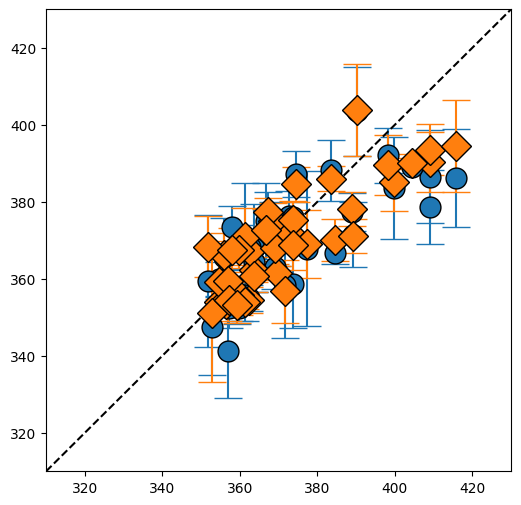

In [144]:
f, ax = plt.subplots(1,1,figsize=(6,6))
y = np.mean([outputs['finetune'][i]['prediction']['test'] for i in range(5)], 0) + 273.15
m = y > 350
print(np.sum(m))
x = outputs['target']['test'][m] + 273.15
markers = ['o','D']
lines = [310, 430]
for j, tune in enumerate(['scratch','finetune']):
    y = np.mean([outputs[tune][i]['prediction']['test'][m] for i in range(5)], 0) + 273.15
    yerr = np.std([outputs[tune][i]['prediction']['test'][m] for i in range(5)], 0)
#    LR.fit(x.reshape(-1,1), y.reshape(-1,1))
#    y_lr = LR.predict([[300], [450]]).reshape(-1)
#    a, b = LR.coef_[0][0], LR.predict([[0]])[0][0]
    ax.errorbar(x, y, yerr=yerr, fmt=markers[j], markersize=15, markeredgecolor=[0,0,0], capsize=10, color=mpl.cm.tab10(j))
#    ax.plot([300, 450], y_lr, color=mpl.cm.tab10(j))
    print('{:10.4f} {:10.4f} {:10.4f} \t {:.3f} x + {:.3f}'.format(r2_score(x, y), mean_absolute_error(x, y), np.corrcoef(x, y)[0,1], a, b))
ax.plot(lines, lines, '--k')
ax.set_xlim(lines)
ax.set_ylim(lines)
#f.savefig('../../figs/output.exp.both.pdf')

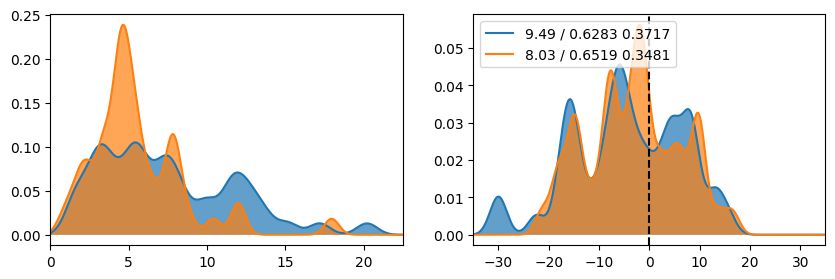

In [263]:

stds = []
aerr_idv = []
aerr_ens = []
for tune in ['scratch','finetune']:
    stds.append(np.std([outputs[tune][i]['prediction']['test'] for i in range(5)], 0))
    aerr_idv.append(np.hstack([outputs[tune][i]['prediction']['test'] - outputs['target']['test'] for i in range(5)]))
    aerr_ens.append(np.mean([outputs[tune][i]['prediction']['test'] for i in range(5)], 0) - outputs['target']['test'])

f, axs = plt.subplots(1,2,figsize=(10, 3))
x = np.linspace(-5,25,1000)
for _std in stds:
    y = gaussian_kde(_std, 0.15)(x)
    axs[0].plot(x, y)
    axs[0].fill_between(x, 0, y, alpha=0.7)
axs[0].set_xlim([0,22.5])

x = np.linspace(-40, 40, 1000)
#for err in aerr_idv:
#    y = gaussian_kde(err, 0.1)(x)
#    axs[1].plot(x, y, label=f'{np.mean(np.abs(err)):.2f}')

for err in aerr_ens:
    y = gaussian_kde(err, 0.15)(x)
    axs[1].fill_between(x, 0, y, alpha=0.7)
    
    axs[1].plot(x, y, label=f'{np.mean(np.abs(err)):.2f} / {np.sum(y[x < 0])/y.sum():.4f} {np.sum(y[x > 0])/y.sum():.4f}')
axs[1].axvline(0, ls='--', color='k')
axs[1].legend(loc='upper left')
axs[1].set_xlim([-35,35])
f.savefig('../../figs/output.stat.test.pdf')

    0.5445     9.4862     0.7832
    0.2589    24.7604     0.9015

    0.6819     8.0264     0.8456
    0.5778    19.2067     0.9212



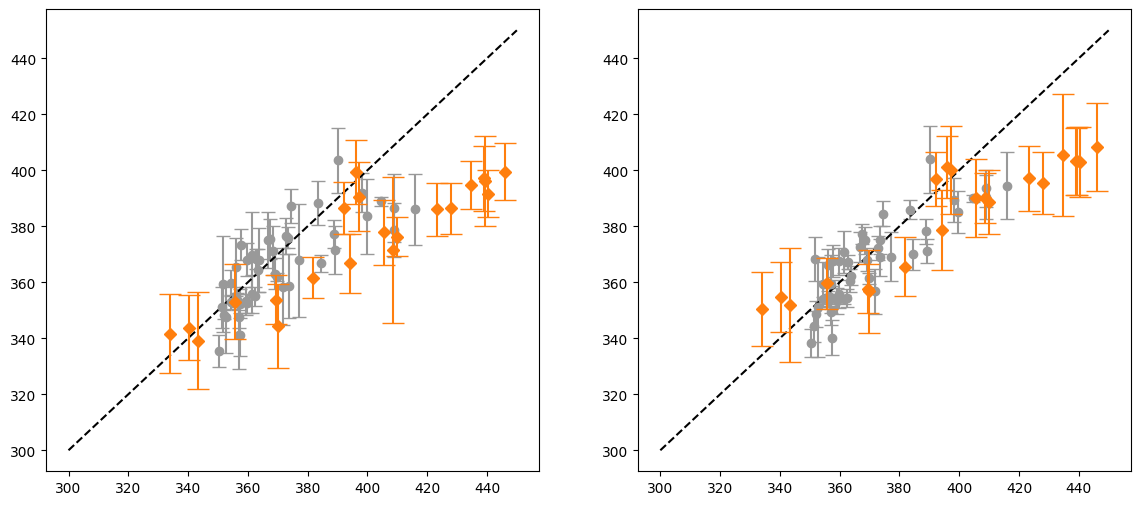

In [113]:

f, axs = plt.subplots(1,2,figsize=(14,6))
y = np.mean([outputs['finetune'][i]['prediction']['exp'] for i in range(5)], 0) + 273.15
x = outputs['target']['exp'] + 273.15
m = y > 350
x = x[m]
lines = np.array([300, 450])
#xx = np.hstack([outputs['target']['train'], outputs['target']['test']]) + 273.15
xx = outputs['target']['test'] + 273.15
for j, tune in enumerate(['scratch','finetune']):
    y = np.mean([outputs[tune][i]['prediction']['exp'][m] for i in range(5)], 0) + 273.15
    yerr = np.std([outputs[tune][i]['prediction']['exp'][m] for i in range(5)], 0)

#    trs = [np.hstack([
#            outputs[tune][i]['prediction']['train'], outputs[tune][i]['prediction']['test'], 
#        ]) for i in range(5)]
    trs = [outputs[tune][i]['prediction']['test'] for i in range(5)]
    yy = np.mean(trs, 0) + 273.15
    yyerr = np.std(trs, 0)
#    LR.fit(x.reshape(-1,1), y.reshape(-1,1))
#    y_lr = LR.predict(lines.reshape(-1,1)).reshape(-1)
#    a, b = LR.coef_[0][0], LR.predict([[0]])[0][0]
    axs[j].errorbar(xx, yy, yerr=yyerr, fmt='o', capsize=5, color=[0.6, 0.6, 0.6])
    axs[j].errorbar(x, y, yerr=yerr, fmt='D', capsize=8, color=mpl.cm.tab10(1), zorder=10)
#    axs[j].plot(lines, y_lr, color=mpl.cm.tab10(j))
    print('{:10.4f} {:10.4f} {:10.4f}'.format(r2_score(xx, yy), mean_absolute_error(xx, yy), np.corrcoef(xx, yy)[0,1]))
    print('{:10.4f} {:10.4f} {:10.4f}'.format(r2_score(x, y), mean_absolute_error(x, y), np.corrcoef(x, y)[0,1]))
    print()

#    print(f'{a:.3f}x + {b:.3f}')
for ax in axs:
    ax.plot(lines, lines, '--k')
